# TESTING HYPERPARAMETERS
# TRANSFORMER. 8 featerow - mag, x, y, depth, dist, distance, plate, days_diff. 
### num_layers=2, d_model=48, num_heads=4

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)

2024-01-12 16:46:29.688857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 16:46:29.690366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 16:46:29.694000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 16:46:30.370047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 16:46:37.393601: W tensorflow/compiler/

In [2]:
ds_train = tf.data.Dataset.load("../data/ds_train/")
ds_val = tf.data.Dataset.load("../data/ds_val/")
ds_test = tf.data.Dataset.load("../data/ds_test/")

2024-01-12 16:46:44.065076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 16:46:44.930154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 16:46:44.930246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 16:46:44.946009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 16:46:44.946138: I tensorflow/compile

In [3]:
ds_train.cardinality().numpy(), ds_val.cardinality().numpy(), ds_test.cardinality().numpy()

(3294436, 465661, 101326)

In [4]:
BATCH_SIZE = 1024
BLOCK_SIZE = 64

In [5]:
def fix_x_and_y(features, context, labels):
    return (features, context), labels

In [6]:
ds_train = ds_train.map(fix_x_and_y)
ds_val = ds_val.map(fix_x_and_y)
ds_test = ds_test.map(fix_x_and_y)

In [7]:
for x, y in ds_train.batch(BATCH_SIZE).take(1):
    print(x[0].shape)
    print(x[1].shape)
    print(y.shape)

(1024, 64, 9)
(1024, 4)
(1024, 1)


In [8]:
# ys = []
# for x, y in ds_train.batch(BATCH_SIZE):
#     ys.append(y.numpy())
# ys = np.concatenate(ys)
# np.bincount(tf.cast(ys, tf.int32).numpy().flatten())

In [9]:
#neg, pos = np.bincount(tf.cast(ys, tf.int32).numpy().flatten())
neg, pos = 3094591, 199845
total = neg + pos
total, pos, neg

(3294436, 199845, 3094591)

In [10]:
ds_train = ds_train.batch(BATCH_SIZE).shuffle(2000, seed=SEED, reshuffle_each_iteration=False).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__(name="positional_embedding")
        self.dense = tf.keras.layers.Dense(d_model // 9 * 6)
        self.embed_dd = tf.keras.layers.Embedding(20, d_model // 9)
        self.embed_plate = tf.keras.layers.Embedding(64, d_model // 9)
        self.embed_magtype = tf.keras.layers.Embedding(20, d_model // 9)
        self.conc = tf.keras.layers.Concatenate()
        self.pos_encoding = tf.keras.layers.Embedding(64, d_model)

    def call(self, x):
        cont, plate, dd, magtype = x
        x1 = self.dense(cont)
        x2 = self.embed_dd(dd)
        x3 = self.embed_plate(plate)
        x4 = self.embed_magtype(magtype)
        x = self.conc([x1, x2, x3, x4])
        x_pos = self.pos_encoding(tf.range(x1.shape[1]))
        x = x + x_pos
        return x

In [41]:
class GlobalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, name, **kwargs):
        super().__init__(name=name)
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs, name="self_attention")
        self.layernorm = tf.keras.layers.LayerNormalization(name="layernorm_self_attention")
        self.add = tf.keras.layers.Add(name="add_self_attention")

    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [42]:
class CrossAttention(tf.keras.layers.Layer):
	def __init__(self, name, **kwargs):
		super().__init__(name=name)
		self.mha = tf.keras.layers.MultiHeadAttention(**kwargs, name="cross_attention")
		self.layernorm = tf.keras.layers.LayerNormalization(name="layernorm_cross_attention")
		self.add = tf.keras.layers.Add(name="add_cross_attention")

	def call(self, x, context):
		attn_output = self.mha(
			query=x,
			key=context,
			value=context)
		x = self.add([x, attn_output])
		x = self.layernorm(x)
		return x

In [32]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu', name="dense"),
            tf.keras.layers.Dense(d_model, name="dense_1"),
            tf.keras.layers.Dropout(dropout_rate, name="dropout_ff")
        ], name="feed_forward")
        self.add = tf.keras.layers.Add(name="add_ff")
        self.layer_norm = tf.keras.layers.LayerNormalization(name="layernorm_ff")

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [53]:
class EncoderBlock(tf.keras.layers.Layer):
	def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
		super().__init__(name="encoder_block")

		self.self_attention = GlobalSelfAttention(
			num_heads=num_heads,
			key_dim=d_model,
			dropout=dropout_rate,
			name="self_attention")

		self.ffn = FeedForward(d_model, dff)

	def call(self, x):
		x = self.self_attention(x)
		x = self.ffn(x)
		return x

In [54]:
class Encoder(tf.keras.models.Model):
    def __init__(self, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
        super().__init__(name='encoder')

        self.d_model = d_model
        self.num_layers = num_layers

        self.dense = tf.keras.layers.Dense(d_model, name="embed_continous")
        self.embed_plate = tf.keras.layers.Embedding(64, d_model, name="embed_plate")
        self.conc = tf.keras.layers.Concatenate(axis=1, name="concatenate")
        self.enc_blocks = [
            EncoderBlock(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(1)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def build_graph(self):
        x = tf.keras.Input(shape=(4), batch_size=None, name="input")
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

    def call(self, x):
        x = self.dropout(x)
        x = tf.reshape(x, (-1, 4, 1))
        cont, plate = x[:, :-1, :], x[:, -1, :]
        x1 = self.dense(cont)
        x2 = self.embed_plate(plate)
        x = self.conc([x1, x2])
        for block in self.enc_blocks:
            x = block(x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [55]:
model = Encoder(num_layers=1, d_model=72, num_heads=2, dff=72 * 4, dropout_rate=0.1)

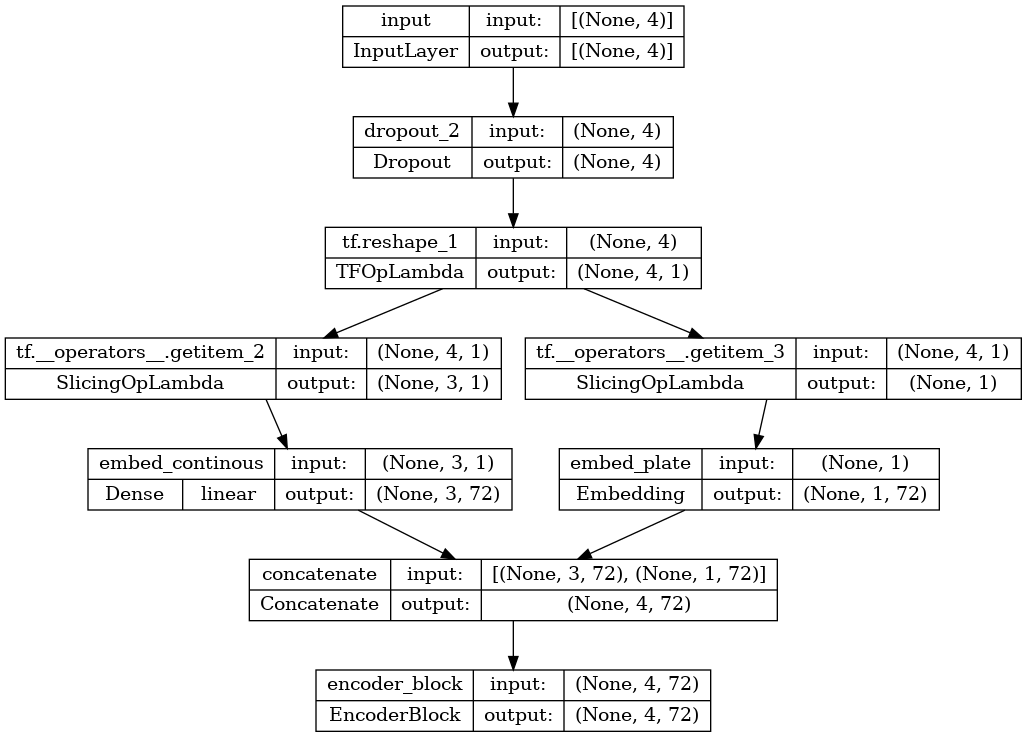

In [56]:
# plot the model architecture
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True, show_layer_activations=True)

In [57]:
class DecoderBlock(tf.keras.models.Model):
    def __init__(self,
                d_model,
                num_heads,
                dff,
                name,
                dropout_rate=0.1):
        super(DecoderBlock, self).__init__(name=name)
        self.d_model = d_model
        self.causal_self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate,
            name="self_attention")

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate,
            name="cross_attention")

        self.ffn = FeedForward(d_model, dff)

    def build_graph(self):
        x = tf.keras.Input(shape=(BLOCK_SIZE, self.d_model), batch_size=None, name="input")
        context = tf.keras.Input(shape=(4, self.d_model), batch_size=None, name="context")
        return tf.keras.Model(inputs=[x, context], outputs=self.call([x, context]))

    def call(self, inputs):
        x, context = inputs
        #x = self.causal_self_attention(x=x)
        x_attn = self.causal_self_attention.mha(x, x, x)
        x = self.causal_self_attention.add([x, x_attn])
        x = self.causal_self_attention.layernorm(x)

        #x = self.cross_attention(x=x, context=context)
        x_attn = self.cross_attention.mha(x, context, context)
        x = self.cross_attention.add([x, x_attn])
        x = self.cross_attention.layernorm(x)

        #x = self.ffn(x)
        x_ffn = self.ffn.seq(x)
        x = self.ffn.add([x, x_ffn])
        x = self.ffn.layer_norm(x)
        return x

In [58]:
model = DecoderBlock(d_model=72, num_heads=2, dff=72 * 4, name="decoder_block")

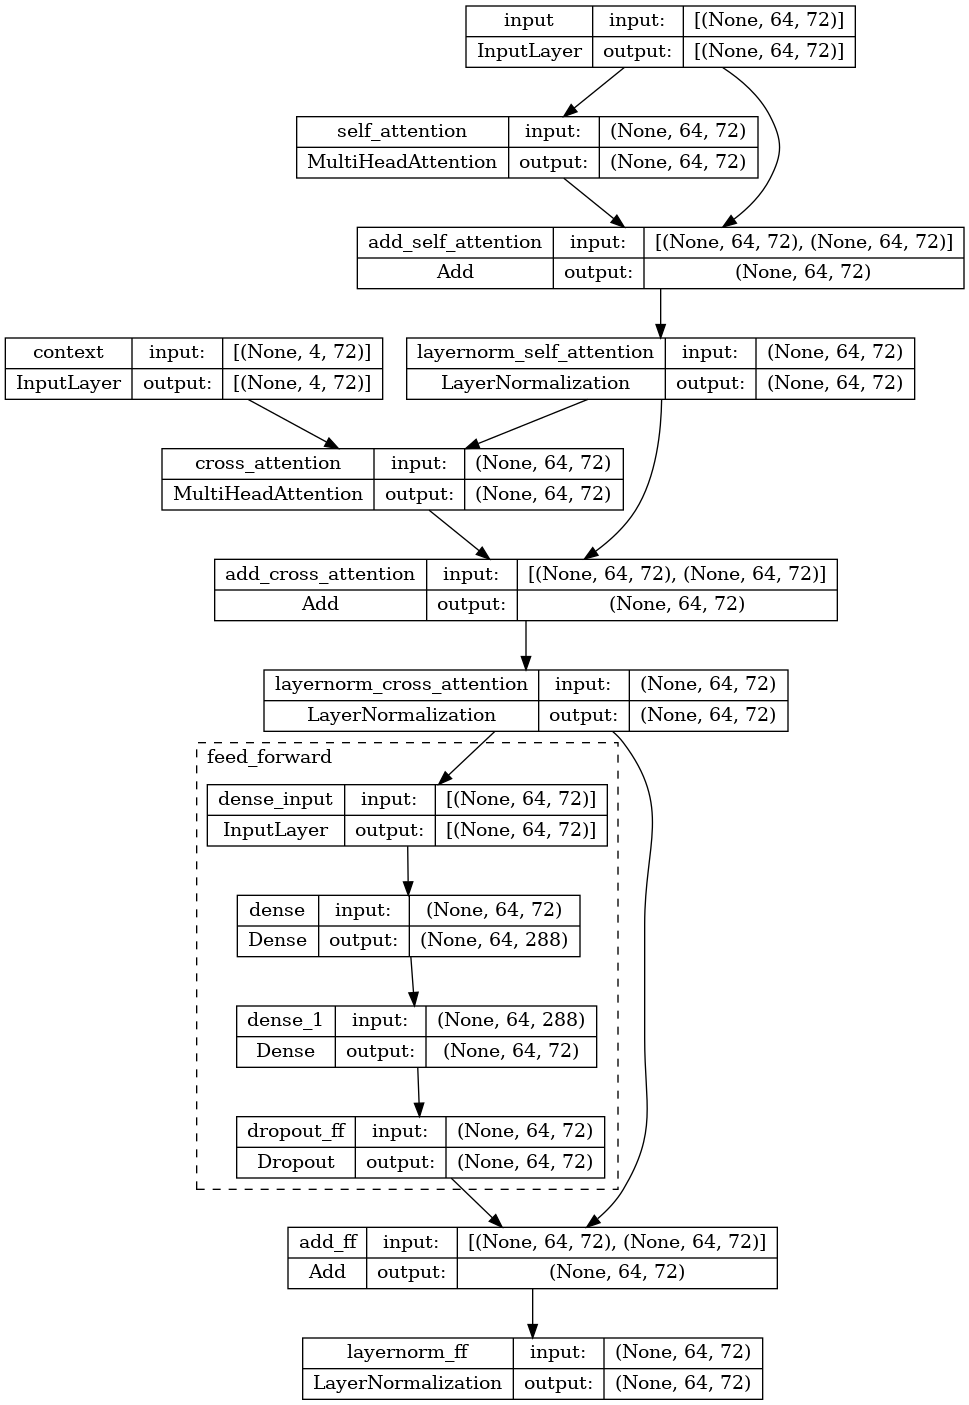

In [59]:
# plot the model architecture
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True)

In [70]:
class Decoder(tf.keras.models.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate=0.1):
        super(Decoder, self).__init__(name='decoder')

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate, name='dropout')
        self.dec_blocks = [
            DecoderBlock(d_model=d_model, num_heads=num_heads,
                        dff=dff, name=f"dec_block{_}", dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        
    def build_graph(self):
        x = [tf.keras.Input(shape=(BLOCK_SIZE, 6), batch_size=None, name="input_continous"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_plate"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_dd"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_magtype")]
        context = tf.keras.Input(shape=(4, self.d_model), batch_size=None, name="encoder")
        return tf.keras.Model(inputs=[x, context], outputs=self.call(x, context))

    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for block in self.dec_blocks:
            x = block(x, context)
        return x

In [71]:
model = Decoder(num_layers=2, d_model=72, num_heads=2, dff=72 * 4, dropout_rate=0.1)

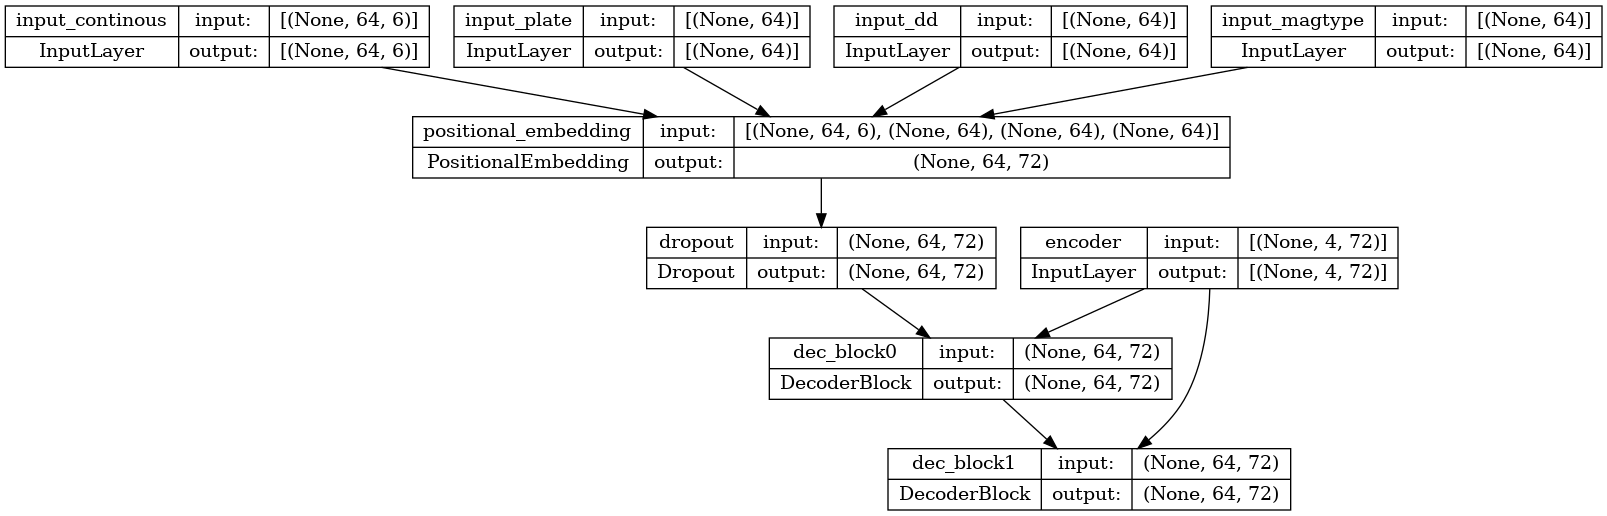

In [72]:
# plot the model architecture
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True)

In [88]:
@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads,
                dropout_rate=0.1):
        super().__init__()
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=4*d_model,
                            dropout_rate=dropout_rate)

        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=4*d_model,
                           dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="classifier")

    def build_graph(self):
        x = [tf.keras.Input(shape=(BLOCK_SIZE, 6), batch_size=None, name="input_continous"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_plate"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_dd"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_magtype")]
        context = [tf.keras.Input(shape=(4), batch_size=None, name="input_context")]
        return tf.keras.Model(inputs=[x, context],
                            outputs=self.call([x, context]))

    def call(self, inputs):
        x, context = inputs
        context = self.encoder(context)
        #x = self.decoder(x, context)

        x = self.decoder.pos_embedding(x)
        x = self.decoder.dropout(x)
        x = self.decoder.dec_blocks[0](x, context)
        x = self.decoder.dec_blocks[1](x, context)
        x = x[:, -1, :]
        logits = self.final_layer(x)
        return logits

In [89]:
model = Transformer(num_layers=2, d_model=72, num_heads=2)

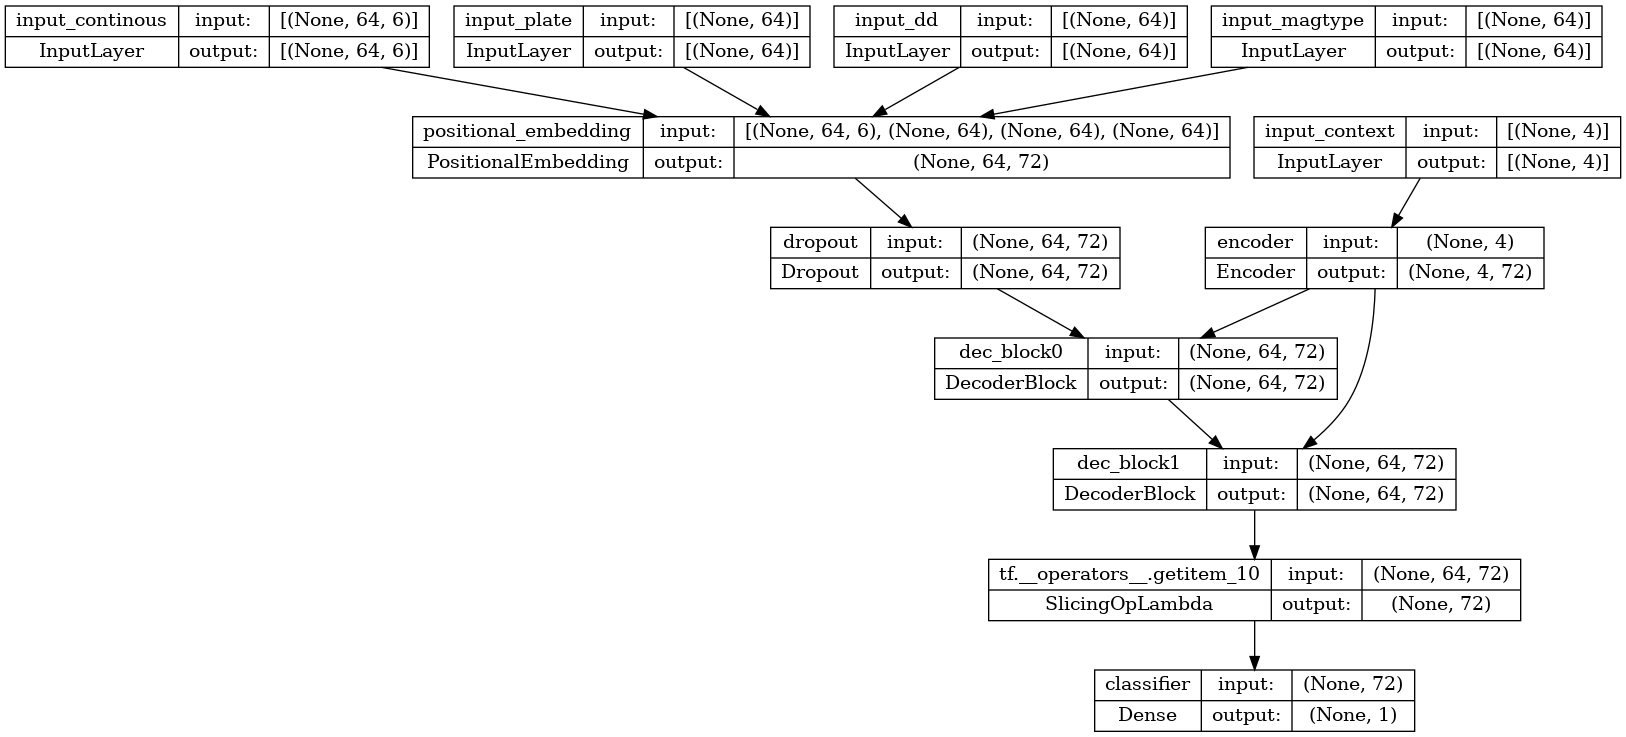

In [90]:
# plot the model architecture
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True)

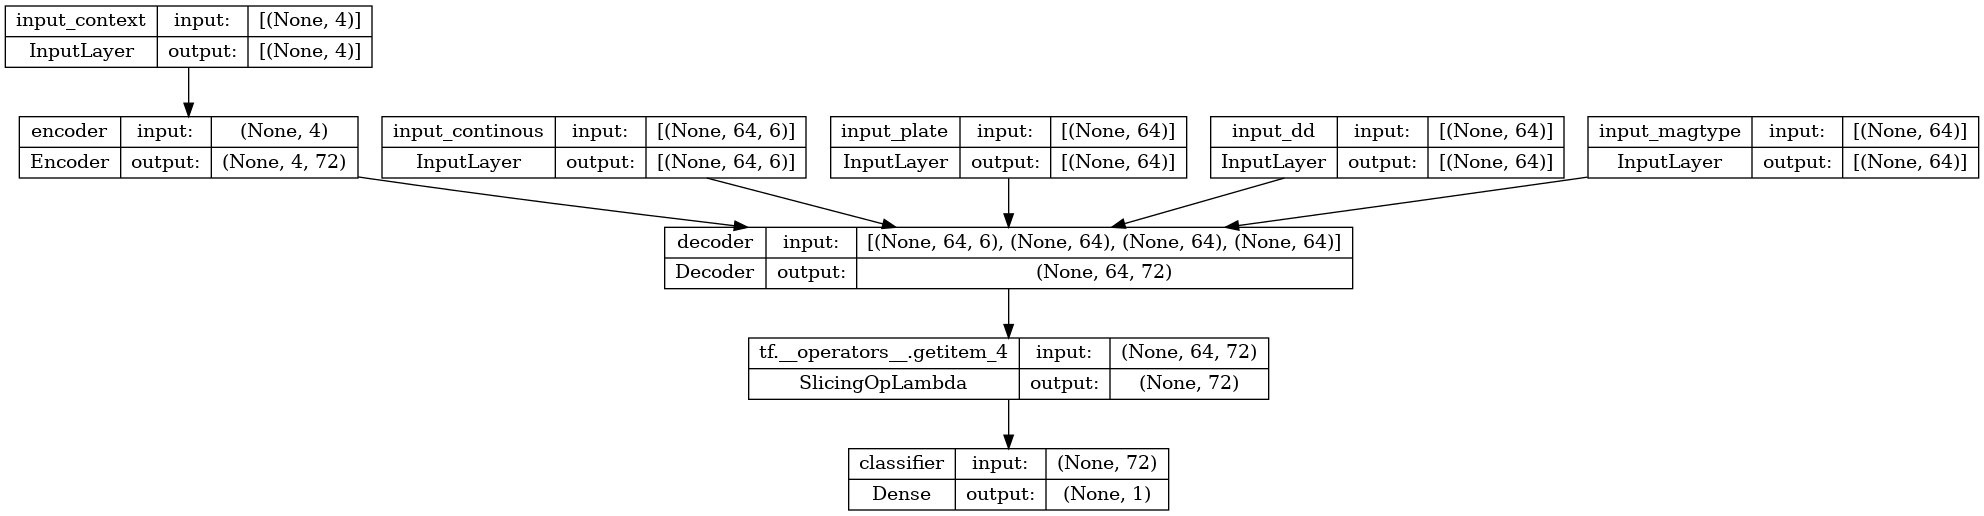

In [55]:
# plot the model architecture
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True)

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer='adam',
            metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [24]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
history = model.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20


2024-01-09 02:11:04.493562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 185 of 2000
2024-01-09 02:11:14.497380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 356 of 2000
2024-01-09 02:11:34.488185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 706 of 2000
2024-01-09 02:11:54.495131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1051 of 2000
2024-01-09 02:12:04.518973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1230 of 2000
2024-01-09 02:12:24.473482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take 

3218/3218 [==============================] - 1949s 563ms/step - loss: 0.1687 - accuracy: 0.9447 - recall: 0.2075 - precision: 0.6344 - val_loss: 0.2005 - val_accuracy: 0.9386 - val_recall: 0.1989 - val_precision: 0.5181
Epoch 2/20


2024-01-09 02:43:25.624098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 153 of 2000
2024-01-09 02:43:45.578884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 460 of 2000
2024-01-09 02:43:55.603549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 624 of 2000
2024-01-09 02:44:05.626438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 786 of 2000
2024-01-09 02:44:25.592679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1060 of 2000
2024-01-09 02:44:35.628545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a

3218/3218 [==============================] - 2489s 727ms/step - loss: 0.1536 - accuracy: 0.9491 - recall: 0.2790 - precision: 0.7022 - val_loss: 0.2008 - val_accuracy: 0.9404 - val_recall: 0.1783 - val_precision: 0.5677
Epoch 3/20


2024-01-09 03:24:55.189688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 145 of 2000
2024-01-09 03:25:05.223694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 305 of 2000
2024-01-09 03:25:25.175002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 632 of 2000
2024-01-09 03:25:35.205600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 792 of 2000
2024-01-09 03:25:45.211985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 947 of 2000
2024-01-09 03:26:05.198832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2529s 732ms/step - loss: 0.1507 - accuracy: 0.9499 - recall: 0.2966 - precision: 0.7072 - val_loss: 0.1999 - val_accuracy: 0.9407 - val_recall: 0.1860 - val_precision: 0.5747
Epoch 4/20


2024-01-09 04:07:04.880519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 148 of 2000
2024-01-09 04:07:14.912434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 284 of 2000
2024-01-09 04:07:34.881516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 448 of 2000
2024-01-09 04:07:44.928006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 529 of 2000
2024-01-09 04:07:54.948186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 623 of 2000
2024-01-09 04:08:14.891542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2631s 742ms/step - loss: 0.1474 - accuracy: 0.9508 - recall: 0.3174 - precision: 0.7116 - val_loss: 0.1936 - val_accuracy: 0.9424 - val_recall: 0.1288 - val_precision: 0.7042
Epoch 5/20


2024-01-09 04:50:55.664782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 158 of 2000
2024-01-09 04:51:05.673639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 321 of 2000
2024-01-09 04:51:25.713859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 583 of 2000
2024-01-09 04:51:45.639123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 779 of 2000
2024-01-09 04:51:55.676187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 880 of 2000
2024-01-09 04:52:15.713402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2589s 740ms/step - loss: 0.1461 - accuracy: 0.9511 - recall: 0.3239 - precision: 0.7136 - val_loss: 0.1950 - val_accuracy: 0.9418 - val_recall: 0.1612 - val_precision: 0.6263
Epoch 6/20


2024-01-09 05:34:05.153110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 44 of 2000
2024-01-09 05:34:25.120131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 151 of 2000
2024-01-09 05:34:44.985175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 283 of 2000
2024-01-09 05:34:55.000213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 354 of 2000
2024-01-09 05:35:05.001258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 433 of 2000
2024-01-09 05:35:15.004662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2634s 736ms/step - loss: 0.1422 - accuracy: 0.9523 - recall: 0.3461 - precision: 0.7227 - val_loss: 0.1895 - val_accuracy: 0.9422 - val_recall: 0.1555 - val_precision: 0.6511
Epoch 7/20


2024-01-09 06:17:59.415174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 148 of 2000
2024-01-09 06:18:19.380429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 420 of 2000
2024-01-09 06:18:29.385469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 539 of 2000
2024-01-09 06:18:39.446704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 604 of 2000
2024-01-09 06:18:59.409931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 810 of 2000
2024-01-09 06:19:09.475812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2652s 750ms/step - loss: 0.1392 - accuracy: 0.9531 - recall: 0.3655 - precision: 0.7260 - val_loss: 0.1878 - val_accuracy: 0.9415 - val_recall: 0.1345 - val_precision: 0.6460
Epoch 8/20


2024-01-09 07:02:11.895967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 34 of 2000
2024-01-09 07:02:21.913648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 71 of 2000
2024-01-09 07:02:41.775739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 165 of 2000
2024-01-09 07:02:51.927832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 211 of 2000
2024-01-09 07:03:11.918255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 338 of 2000
2024-01-09 07:03:31.865745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a wh

3218/3218 [==============================] - 2643s 743ms/step - loss: 0.1363 - accuracy: 0.9541 - recall: 0.3781 - precision: 0.7379 - val_loss: 0.1919 - val_accuracy: 0.9413 - val_recall: 0.1303 - val_precision: 0.6423
Epoch 9/20


2024-01-09 07:46:15.808426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 41 of 2000
2024-01-09 07:46:35.649024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 127 of 2000
2024-01-09 07:46:45.749799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 185 of 2000
2024-01-09 07:47:05.654179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 323 of 2000
2024-01-09 07:47:25.648497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 479 of 2000
2024-01-09 07:47:45.656472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2635s 741ms/step - loss: 0.1339 - accuracy: 0.9547 - recall: 0.3885 - precision: 0.7419 - val_loss: 0.1894 - val_accuracy: 0.9414 - val_recall: 0.1414 - val_precision: 0.6299
Epoch 10/20


2024-01-09 08:30:10.329389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 81 of 2000
2024-01-09 08:30:30.405313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 217 of 2000
2024-01-09 08:30:50.414611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 351 of 2000
2024-01-09 08:31:10.416781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 494 of 2000
2024-01-09 08:31:30.355855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 678 of 2000
2024-01-09 08:31:40.983876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2654s 737ms/step - loss: 0.1331 - accuracy: 0.9547 - recall: 0.3879 - precision: 0.7434 - val_loss: 0.1872 - val_accuracy: 0.9416 - val_recall: 0.1509 - val_precision: 0.6298
Epoch 11/20


2024-01-09 09:14:24.313069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 52 of 2000
2024-01-09 09:14:34.343287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 134 of 2000
2024-01-09 09:14:44.413873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 187 of 2000
2024-01-09 09:15:04.299406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 302 of 2000
2024-01-09 09:15:24.293073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 417 of 2000
2024-01-09 09:15:34.341735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2653s 732ms/step - loss: 0.1309 - accuracy: 0.9554 - recall: 0.3974 - precision: 0.7501 - val_loss: 0.1880 - val_accuracy: 0.9408 - val_recall: 0.1347 - val_precision: 0.6141
Epoch 12/20


2024-01-09 09:58:37.170996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 104 of 2000
2024-01-09 09:58:47.223719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 216 of 2000
2024-01-09 09:59:07.210387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 483 of 2000
2024-01-09 09:59:17.227458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 584 of 2000
2024-01-09 09:59:27.320932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 672 of 2000
2024-01-09 09:59:47.172351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2597s 737ms/step - loss: 0.1297 - accuracy: 0.9554 - recall: 0.3992 - precision: 0.7476 - val_loss: 0.1940 - val_accuracy: 0.9379 - val_recall: 0.1411 - val_precision: 0.5043
Epoch 13/20


2024-01-09 10:41:54.404979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 42 of 2000
2024-01-09 10:42:04.415148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 88 of 2000
2024-01-09 10:42:14.557996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 132 of 2000
2024-01-09 10:42:34.408627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 247 of 2000
2024-01-09 10:42:54.481168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 374 of 2000
2024-01-09 10:43:14.434228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a wh

3218/3218 [==============================] - 2670s 744ms/step - loss: 0.1299 - accuracy: 0.9554 - recall: 0.4006 - precision: 0.7458 - val_loss: 0.1833 - val_accuracy: 0.9414 - val_recall: 0.1421 - val_precision: 0.6303
Epoch 14/20


2024-01-09 11:26:24.472134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 97 of 2000
2024-01-09 11:26:44.466370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 196 of 2000
2024-01-09 11:27:04.417393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 292 of 2000
2024-01-09 11:27:14.465127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 349 of 2000
2024-01-09 11:27:24.482472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 418 of 2000
2024-01-09 11:27:44.392954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2653s 737ms/step - loss: 0.1277 - accuracy: 0.9560 - recall: 0.4133 - precision: 0.7496 - val_loss: 0.1780 - val_accuracy: 0.9421 - val_recall: 0.1643 - val_precision: 0.6366
Epoch 15/20


2024-01-09 12:10:37.860221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 40 of 2000
2024-01-09 12:10:57.737563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 126 of 2000
2024-01-09 12:11:07.802610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 175 of 2000
2024-01-09 12:11:27.790795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 279 of 2000
2024-01-09 12:11:47.661031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 395 of 2000
2024-01-09 12:12:07.653609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2645s 732ms/step - loss: 0.1265 - accuracy: 0.9565 - recall: 0.4207 - precision: 0.7529 - val_loss: 0.1827 - val_accuracy: 0.9408 - val_recall: 0.1453 - val_precision: 0.6006
Epoch 16/20


2024-01-09 12:54:43.503014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 151 of 2000
2024-01-09 12:55:03.486171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 466 of 2000
2024-01-09 12:55:13.489225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 602 of 2000
2024-01-09 12:55:23.499915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 676 of 2000
2024-01-09 12:55:33.503179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 742 of 2000
2024-01-09 12:55:53.479918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2343s 671ms/step - loss: 0.1242 - accuracy: 0.9571 - recall: 0.4349 - precision: 0.7528 - val_loss: 0.1829 - val_accuracy: 0.9403 - val_recall: 0.1390 - val_precision: 0.5873
Epoch 17/20


2024-01-09 13:33:47.034674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 35 of 2000
2024-01-09 13:34:06.946205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 162 of 2000
2024-01-09 13:34:16.957318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 231 of 2000
2024-01-09 13:34:27.012143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 296 of 2000
2024-01-09 13:34:37.648259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 358 of 2000
2024-01-09 13:34:56.932625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 1234s 290ms/step - loss: 0.1242 - accuracy: 0.9571 - recall: 0.4350 - precision: 0.7542 - val_loss: 0.1792 - val_accuracy: 0.9422 - val_recall: 0.1673 - val_precision: 0.6367
Epoch 18/20


2024-01-09 13:54:22.037518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 38 of 2000
2024-01-09 13:54:32.067646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 84 of 2000
2024-01-09 13:54:51.985662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 324 of 2000
2024-01-09 13:55:02.025890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 392 of 2000
2024-01-09 13:55:12.127954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 453 of 2000
2024-01-09 13:55:32.139052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a wh

3218/3218 [==============================] - 1194s 270ms/step - loss: 0.1230 - accuracy: 0.9575 - recall: 0.4387 - precision: 0.7584 - val_loss: 0.1813 - val_accuracy: 0.9419 - val_recall: 0.1622 - val_precision: 0.6320
Epoch 19/20


2024-01-09 14:14:17.208433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 89 of 2000
2024-01-09 14:14:37.147189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 254 of 2000
2024-01-09 14:14:47.154362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 337 of 2000
2024-01-09 14:14:57.185146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 417 of 2000
2024-01-09 14:15:17.123503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 579 of 2000
2024-01-09 14:15:27.140268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 1140s 268ms/step - loss: 0.1203 - accuracy: 0.9584 - recall: 0.4549 - precision: 0.7634 - val_loss: 0.1788 - val_accuracy: 0.9418 - val_recall: 0.2861 - val_precision: 0.5642
Epoch 20/20


2024-01-09 14:33:18.462891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 47 of 2000
2024-01-09 14:33:38.326374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 234 of 2000
2024-01-09 14:33:58.294469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 418 of 2000
2024-01-09 14:34:08.389577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 492 of 2000
2024-01-09 14:34:28.384752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 627 of 2000
2024-01-09 14:34:48.395054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 1148s 268ms/step - loss: 0.1205 - accuracy: 0.9583 - recall: 0.4526 - precision: 0.7639 - val_loss: 0.1796 - val_accuracy: 0.9426 - val_recall: 0.3101 - val_precision: 0.5715


In [25]:
model.evaluate(ds_test)

99/99 [==============================] - 10s 100ms/step - loss: 0.0878 - accuracy: 0.9782 - recall: 0.2894 - precision: 0.5309


[0.08784053474664688,
 0.9782187938690186,
 0.2894045412540436,
 0.5309237241744995]

In [26]:
model.save("../models/model_v2.keras")

In [27]:
# save history
history = pd.DataFrame.from_dict(history.history)
history.to_csv("../models/history_model_v2.csv", index=False)